In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
def simulate_xt(x0, t):
    t = t.view(-1, 1)
    m_t = torch.exp(-t)
    sigma_t = torch.sqrt(1 - torch.exp(-2 * t))
    z = torch.randn_like(x0)
    xt = m_t * x0 + sigma_t * z
    return xt, z, m_t, sigma_t

In [3]:
N_SAMPLES = 100_000

In [4]:
def generate_exp_data(lam=1.0, n_samples=200_000, device='cpu'):
    d = 2
    x0 = torch.distributions.Exponential(rate=lam).sample((n_samples, d)).to(device)

    t = torch.rand(n_samples, 1, device=device) * 3.0

    m_t = torch.exp(-t)
    z = torch.randn(n_samples, d, device=device)
    xt = m_t * x0 + torch.sqrt(1 - m_t**2) * z

    return x0, t, z, xt

In [5]:
device = "cpu"

In [6]:
class ScoreNet(nn.Module):
    def __init__(self, d=2, N=64, activation='relu'):
        super().__init__()
        self.N = N
        self.d = d

        self.w = nn.Parameter(torch.randn(N, d))
        self.b = nn.Parameter(torch.randn(N))
        self.a = nn.Parameter(torch.randn(N, d))

        if activation == 'relu':
            self.activation = torch.relu
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        else:
            raise ValueError("Unknown activation")

    def forward(self, t, x):
        B = x.shape[0]

        x_exp = x.unsqueeze(1)
        w_exp = self.w.unsqueeze(0)
        b_exp = self.b.unsqueeze(0).unsqueeze(-1)
        a_exp = self.a.unsqueeze(0)

        inner = torch.sum(w_exp * x_exp, dim=-1, keepdim=True)
        h = self.activation(inner + b_exp)
        contrib = h * a_exp

        return contrib.mean(dim=1)

In [7]:
def compute_H(net, x0, t, z):
    B, d = x0.shape
    m_t = torch.exp(-t)
    sigma_t = torch.sqrt(1 - torch.exp(-2 * t))
    kappa_t = sigma_t ** 2
    x_t = m_t * x0 + sigma_t * z
    x_t.requires_grad_(True)

    s = net(t, x_t)

    total_grad = [torch.zeros_like(p) for p in net.parameters()]

    for i in range(B):
        x_i = x_t[i]
        z_i = z[i]
        t_i = t[i].unsqueeze(0)
        s_i = s[i]
        sigma_inv_z = z_i / sigma_t[i]
        coeff = sigma_inv_z + s_i

        for j in range(d):
            grad_sij = torch.autograd.grad(
                outputs=s_i[j],
                inputs=list(net.parameters()),
                retain_graph=True,
                create_graph=True,
                allow_unused=True
            )

            for k in range(len(total_grad)):
                if grad_sij[k] is not None:
                    total_grad[k] += 2 * kappa_t[i, 0] * coeff[j] * grad_sij[k]

    return total_grad

In [8]:
def sgld_update(params, grads, lr, beta):
    updated = []
    for p, g in zip(params, grads):
        noise = torch.randn_like(p)
        noise_scale = (2 * lr / beta) ** 0.5
        p_new = p - lr * g + noise_scale * noise
        updated.append(p_new)
    return updated

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = ScoreNet(d=2).to(device)
B, d = 128, 2
lr = 1e-3
beta = 10**8
num_steps = 10000

a0_vals = []
w0_vals = []
b0_vals = []
theta_trajectory = []
a_vals_all = []
w_vals_all = []
b_vals_all = []
grad_norms = []

for step in range(num_steps):
    x0, t, z, _ = generate_exp_data(lam=1.0, n_samples=B, device=device)

    grads = compute_H(net, x0, t, z)
    grad_norm = torch.sqrt(sum(g.norm()**2 for g in grads if g is not None))
    grad_norms.append(grad_norm.item())

    updated_params = sgld_update(list(net.parameters()), grads, lr, beta)
    
    with torch.no_grad():
        for p, new_p in zip(net.parameters(), updated_params):
            p.copy_(new_p)

        a0_vals.append(torch.norm(net.a, dim=1).mean().item())
        w0_vals.append(torch.norm(net.w, dim=1).mean().item())
        b0_vals.append(net.b.mean().item())
        
        a_vals_all.append(net.a.clone().cpu())
        w_vals_all.append(net.w.clone().cpu())
        b_vals_all.append(net.b.clone().cpu())

        theta = torch.cat([
            net.a.flatten(),
            net.w.flatten(),
            net.b.flatten()
        ])
        theta_trajectory.append(theta.clone().cpu().numpy())
        theta_final = torch.cat([p.flatten() for p in net.parameters()])

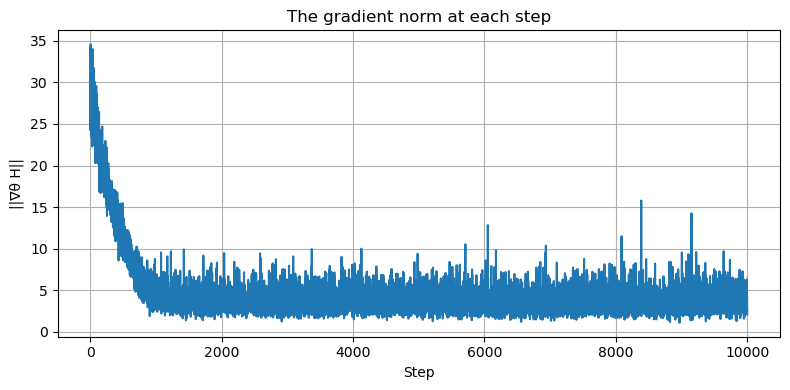

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(grad_norms)
plt.title("The gradient norm at each step")
plt.xlabel("Step")
plt.ylabel("||∇θ H||")
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm

N_samples = 6000
dim = 2
gamma = 1e-6
K = 2000
T = 3.0
timesteps = np.linspace(0, T, K + 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Y = torch.randn(N_samples, dim, device=device)
net.eval()

for k in tqdm(range(K)):
    t_k = timesteps[k]
    tau = torch.tensor([T - t_k], device=device)

    tau_batch = tau.expand(N_samples, 1)
    
    with torch.no_grad():
        s_val = net(tau_batch, Y)

    drift = Y + 2 * s_val
    noise = torch.randn_like(Y)
    Y = Y + gamma * drift + torch.sqrt(torch.tensor(2 * gamma)) * noise
    Y = torch.abs(Y)

samples = Y.detach().cpu().numpy()


100%|██████████████████████████████████████| 2000/2000 [00:02<00:00, 693.21it/s]


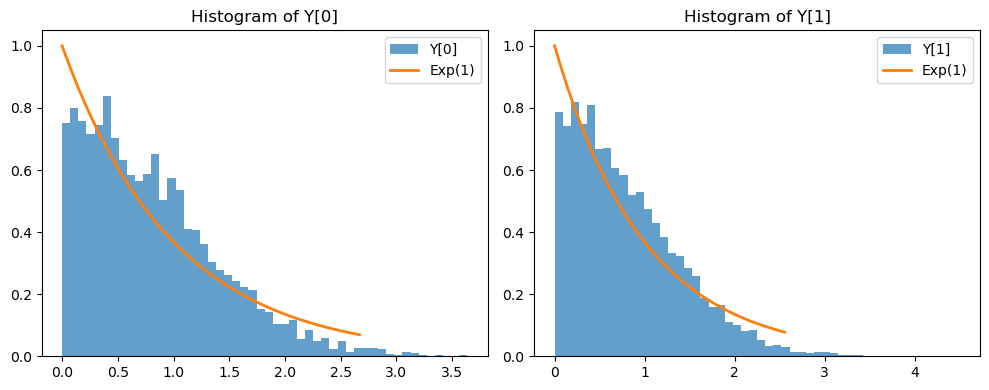

In [12]:
from scipy.stats import expon

plt.figure(figsize=(10, 4))
for i in range(dim):
    plt.subplot(1, dim, i+1)
    plt.hist(samples[:, i], bins=50, density=True, alpha=0.7, label=f"Y[{i}]")

    x_vals = np.linspace(0, np.percentile(samples[:, i], 99), 200)
    plt.plot(x_vals, expon.pdf(x_vals), label="Exp(1)", linewidth=2)
    plt.title(f"Histogram of Y[{i}]")
    plt.legend()

plt.tight_layout()
plt.show()


In [14]:
@torch.no_grad()
def w2_1d_empirical_vs_exp(samples_1d: torch.Tensor, lam: float = 1.0, return_squared=False):

    x = samples_1d.flatten()
    n = x.numel()
    xs, _ = torch.sort(x)                    
    i = torch.arange(1, n+1, device=x.device, dtype=x.dtype)
    u = (i - 0.5) / n
    q = -torch.log1p(-u) / lam

    w2_sq = torch.mean((xs - q)**2)
    return w2_sq if return_squared else torch.sqrt(w2_sq + 1e-12)

In [15]:
S = torch.from_numpy(samples)
w2_x0 = w2_1d_empirical_vs_exp(S[:,0], lam=1.0)
w2_x1 = w2_1d_empirical_vs_exp(S[:,1], lam=1.0)
print(f"W2 vs Exp(1):  X[0]={float(w2_x0):.4f},  X[1]={float(w2_x1):.4f}")


W2 vs Exp(1):  X[0]=0.4654,  X[1]=0.4697
